In [1]:
from torchsat.models.segmentation.unet import UNetResNet

import rasterio as rio
import numpy as np
import os, sys
# add the unet helpers
sys.path.append('../../')
# from test_unet_helpers import *
from utils import variable
from unet_models import unet11_MS

import utils as pyt_utils
from torch.optim import Adam
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from validation import validation_binary
from loss import LossBinary
import json
from torch import nn
import torch
import torch.nn.functional as F

from glob import glob
import time
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score, precision_recall_fscore_support

In [2]:
class DG_GT_Dataset(Dataset):
    """Dataset class DG and GT data"""
    
    def __init__(self, data_dir, channels='all', img_transform=None, gt_transform=None, rot=False):
        """ 
        Args:
            data_dir (string): the folder containing the image files
            channels (string): 'all', 'bgr', 'bgrn1', 'bgrn2'; band sets for DG imagery
            img_transform (callable, optional): Optional transform to  be applied to source image data
            gt_transform (callable, optional): Optional transform to  be applied to labeled image data
            x_var (iterable, optional): list of predictor variable names
            land_mask (string, optional): defines whether or not to return land mask
        """
        
        # some sanity checks
        assert os.path.exists(data_dir)
        
        self.gt_files = sorted(glob(data_dir + '/gt*.tif'))
        self.img_files = sorted(glob(data_dir + '/dg*.tif'))
        
        
        print(self.img_files[0])
        print(self.gt_files[0])
        
        self.img_transform = img_transform
        self.gt_transform = gt_transform
        self.dg_bgr = [1,2,4]
        self.dg_bgrn1 = [1,2,4,6]
        self.dg_bgrn2 = [1,2,4,7]
        self.channels = channels
        self.rot = rot
        
        assert len(self.img_files) == len(self.gt_files)
        
    
    def __getitem__(self, idx):
        
        """
            Files are organized as <var_type>_<year>_<month>_t<tileNumber>.tif, e.g., Arson_1992_1_t1
            A single dataset needs to be constructed for a given ignition type, year, month, and tile number
        """
        
        img_file = self.img_files[idx]
        gt_file = self.gt_files[idx]
        
        with rio.open(img_file) as src:
            img_arr = src.read()
            
        # check the channels
        if self.channels == 'bgr':
            img_arr = img_arr[self.dg_bgr, :, :]
        elif self.channels == 'bgrn1':
            img_arr = img_arr[self.dg_bgrn1, :, :]
        elif self.channels == 'bgrn2':
            img_arr = img_arr[self.dg_brgn2, :, :]
        else:
            pass
            
        with rio.open(gt_file) as src:
            gt_arr = src.read()
            
        #print(img_arr.shape, gt_arr.shape)

        # first consider the rotation argument
        if self.rot:
            dg_t = torch.from_numpy(img_arr)
            gt_t = torch.from_numpy(gt_arr)
            
            # get a random number
            rot_p = np.random.random()*100
            
            # do nothing
            if rot_p < 15:
                
                return (dg_t, gt_t)
            
            elif (rot_p >= 15) and (rot_p < 50):
                
                dg_rot = dg_t.transpose(1,2)
                gt_rot = gt_t.transpose(1,2)
                
                return (dg_rot, gt_t)
            
            elif (rot_p >= 50) and (rot_p < 75):
                
                dg_rot = dg_t.flip(1).flip(2)
                gt_rot = gt_t.flip(1).flip(2)
                
                return (dg_rot, gt_rot)
                
            else:
            
                dg_rot = dg_t.transpose(1,2).flip(2) #t90 CCW
                gt_rot = gt_t.transpose(1,2).flip(2)
                
                return(dg_rot, gt_rot)
            


        if (self.img_transform is not None):
            return (self.img_transform(torch.from_numpy(img_arr)), 
                    self.gt_transform(torch.from_numpy(gt_arr)))   
        else:
            return (torch.from_numpy(img_arr), torch.from_numpy(gt_arr)) # return X, Y, Mask (Mask uses LandMask in X-var folder)
            
        
    def __len__(self):
        return len(self.img_files)

In [3]:
from datetime import datetime

def write_event(log, step: int, **data):
    data['step'] = step
    data['dt'] = datetime.now().isoformat()
    log.write(json.dumps(data, sort_keys=True))
    log.write('\n')
    log.flush()
    
save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))

In [4]:
torch.manual_seed(0)
np.random.seed(0)
cudnn.benchmark = False
cudnn.deterministic = True

In [5]:
# aws paths
train_folder = '../../../tiles/kmeans3_split/tiles_d10000_256x256/train'
test_folder = '../../../tiles/kmeans3_split/tiles_d10000_256x256/test'
val_folder = '../../../tiles/kmeans3_split/tiles_d10000_256x256/val'

# load as 4 band
ps_train_ds = DG_GT_Dataset(train_folder, channels='bgr')
ps_train_ds_rot = DG_GT_Dataset(train_folder, channels='bgr', rot=True)

ps_test_ds = DG_GT_Dataset(test_folder, channels='bgr')
ps_val_ds = DG_GT_Dataset(val_folder, channels='bgr')

../../../tiles/kmeans3_split/tiles_d10000_256x256/train/dg_is_00000.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/train/gt_is_00000.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/train/dg_is_00000.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/train/gt_is_00000.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/test/dg_is_00731.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/test/gt_is_00731.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/val/dg_is_00500.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/val/gt_is_00500.tif


In [6]:
# iterate over some batch sizes
times = []

# set some parameters
lr = 0.001
bsize = 32 # was 32

ps_model = UNetResNet(encoder_depth=152, num_classes=1, in_channels=3, num_filters=32, dropout_2d=0.2,
                 pretrained=True, is_deconv=True)

ps_optimizer = Adam(ps_model.parameters(), lr=lr)
ps_criterion = LossBinary(jaccard_weight=1.0)

###### specify DataLoaders
n_workers=torch.cuda.device_count()*2
ps_train_rot_dl = DataLoader(ps_train_ds_rot, batch_size=bsize, shuffle=True, num_workers=n_workers)
ps_test_dl = DataLoader(ps_test_ds, batch_size=bsize, shuffle=True, num_workers=n_workers)


# make model parallel and on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # get device for gpu or cpu
if torch.cuda.device_count() >= 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    ps_model = nn.DataParallel(ps_model)
    ps_model.to(device)
else:
    #ps_model = nn.DataParallel(ps_model)
    print('made cpu parallel')

Let's use 4 GPUs!


In [7]:
 torch.cuda.device_count()

4

In [8]:
print('batchsize, ', bsize)
ps_mean_loss = 0.0
ps_running_loss = 0.0
print('training...')

ps_losses=[]
ps_losses_ep = []
ps_step=0

# record time for one epoch
ps_rocs = []
ps_f1 = []
ps_prec = []
ps_recall = []
ps_f1_ep = []
ps_mAP_ep = []
ps_mAR_ep = []

#####################################################

t0 = time.time()
num_epochs = 500
ctr=0
ps_model.train()
for epoch in range(num_epochs):
    

    te = time.time()

    epoch_i = epoch+1
    print('on epoch {}'.format(epoch_i))

    running_loss = 0
    
        
    _ps_rocs = []
    _ps_f1 = []
    _ps_prec = []
    _ps_recall = []
    for i, (inputs_, targets_) in enumerate(ps_train_rot_dl):

        #print('hi')

        # get the inputs
        targets_ = targets_.type(torch.FloatTensor)

        #inputs, targets = variable(inputs_).cuda(), variable(targets_).cuda()
        inputs, targets = variable(inputs_), variable(targets_)
        inputs.to(device)
        targets.to(device)

        outputs = ps_model(inputs)

        # zero parameter gradients
        ps_optimizer.zero_grad()

        # forward + backward + optimize            
        i_loss = ps_criterion(outputs, targets)
        i_loss.backward()
        ps_optimizer.step()
        ps_step+=1

        running_loss += i_loss

        #record iterations f1, precision, recall
        _f1 = f1_score(targets.cpu().data.numpy().flatten(), outputs.cpu().data.numpy().squeeze().flatten() > 0., average='binary')
        _ps_f1.append(_f1)
        _prec = precision_score(targets.cpu().data.numpy().flatten(), outputs.cpu().data.numpy().squeeze().flatten() > 0, average='binary')
        _ps_prec.append(_prec)
        _recall = recall_score(targets.cpu().data.numpy().flatten(), outputs.cpu().data.numpy().squeeze().flatten() > 0, average='binary')
        _ps_recall.append(_recall)

        if i%5 == 0: # print/store every 5
            ps_losses.append(i_loss)
            
    # append precision and recall metrics
    ps_f1 += _ps_f1
    ps_prec += _ps_prec
    ps_recall += _ps_recall

    ps_f1_ep.append(np.mean(_ps_f1))
    ps_mAP_ep.append(np.mean(_ps_prec))
    ps_mAR_ep.append(np.mean(_ps_recall))

    # get some numbers for the ROC curve
    if epoch_i%2 == 0:
        pred_y = outputs.cpu().data.numpy().squeeze().flatten()
        target_y = targets.cpu().data.numpy().flatten()
        tu = (i_loss, roc_auc_score(target_y,pred_y ))
        print ('epoch: {}, LOSS={}, ROC_AUC={} '.format(epoch_i, *tu))  
        ps_rocs.append(tu[1])


    ps_losses_ep.append(running_loss)
    te1 = time.time()
    print('time for epoch {}: {} seconds'.format(epoch_i, te1-te))

        

        
t1 = time.time()
print ('total time: ',t1 - t0)
times.append(t1-t0)

batchsize,  32
training...
on epoch 1


/home/ubuntu/anaconda3/envs/spatial_torch2/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/ubuntu/anaconda3/envs/spatial_torch2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/envs/spatial_torch2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


time for epoch 1: 39.33788824081421 seconds
on epoch 2
epoch: 2, LOSS=1.3643865585327148, ROC_AUC=0.6699802260756214 
time for epoch 2: 29.65021562576294 seconds
on epoch 3
time for epoch 3: 29.72905707359314 seconds
on epoch 4
epoch: 4, LOSS=1.2526774406433105, ROC_AUC=0.7082562803187537 
time for epoch 4: 30.330838203430176 seconds
on epoch 5
time for epoch 5: 30.026082515716553 seconds
on epoch 6
epoch: 6, LOSS=1.1623300313949585, ROC_AUC=0.7386566908684944 
time for epoch 6: 30.51463794708252 seconds
on epoch 7
time for epoch 7: 30.230655908584595 seconds
on epoch 8
epoch: 8, LOSS=1.1332083940505981, ROC_AUC=0.7427959559552564 
time for epoch 8: 30.281391620635986 seconds
on epoch 9
time for epoch 9: 30.093544960021973 seconds
on epoch 10
epoch: 10, LOSS=1.1683828830718994, ROC_AUC=0.7633679484886211 
time for epoch 10: 30.281446933746338 seconds
on epoch 11
time for epoch 11: 30.45035719871521 seconds
on epoch 12
epoch: 12, LOSS=1.1451188325881958, ROC_AUC=0.7537149529560344 
time

time for epoch 93: 31.125812292099 seconds
on epoch 94
epoch: 94, LOSS=0.766055166721344, ROC_AUC=0.904189427031969 
time for epoch 94: 31.35811495780945 seconds
on epoch 95
time for epoch 95: 31.12351942062378 seconds
on epoch 96
epoch: 96, LOSS=0.6798748970031738, ROC_AUC=0.911143595799174 
time for epoch 96: 31.31083869934082 seconds
on epoch 97
time for epoch 97: 31.155030250549316 seconds
on epoch 98
epoch: 98, LOSS=0.6626095771789551, ROC_AUC=0.9161365569764401 
time for epoch 98: 31.303807258605957 seconds
on epoch 99
time for epoch 99: 31.04783034324646 seconds
on epoch 100
epoch: 100, LOSS=0.755361795425415, ROC_AUC=0.90113469139731 
time for epoch 100: 31.619600534439087 seconds
on epoch 101
time for epoch 101: 31.033597946166992 seconds
on epoch 102
epoch: 102, LOSS=0.6897903680801392, ROC_AUC=0.9176844929313647 
time for epoch 102: 31.332281589508057 seconds
on epoch 103
time for epoch 103: 31.279237747192383 seconds
on epoch 104
epoch: 104, LOSS=0.728187084197998, ROC_AUC=

time for epoch 183: 31.511228561401367 seconds
on epoch 184
epoch: 184, LOSS=0.6828577518463135, ROC_AUC=0.924348393433817 
time for epoch 184: 32.223448038101196 seconds
on epoch 185
time for epoch 185: 31.607845306396484 seconds
on epoch 186
epoch: 186, LOSS=0.528327226638794, ROC_AUC=0.9464278085189627 
time for epoch 186: 32.070640563964844 seconds
on epoch 187
time for epoch 187: 31.831587314605713 seconds
on epoch 188
epoch: 188, LOSS=0.504871666431427, ROC_AUC=0.9521066078635608 
time for epoch 188: 31.88892960548401 seconds
on epoch 189
time for epoch 189: 31.77503228187561 seconds
on epoch 190
epoch: 190, LOSS=0.6137040853500366, ROC_AUC=0.9416086229450058 
time for epoch 190: 32.04724454879761 seconds
on epoch 191
time for epoch 191: 31.600791931152344 seconds
on epoch 192
epoch: 192, LOSS=0.46483510732650757, ROC_AUC=0.9562403412957907 
time for epoch 192: 32.20860242843628 seconds
on epoch 193
time for epoch 193: 31.861701011657715 seconds
on epoch 194
epoch: 194, LOSS=0.52

time for epoch 273: 32.41967058181763 seconds
on epoch 274
epoch: 274, LOSS=0.4572140872478485, ROC_AUC=0.9642907267529004 
time for epoch 274: 32.48114037513733 seconds
on epoch 275
time for epoch 275: 32.371686935424805 seconds
on epoch 276
epoch: 276, LOSS=0.48644399642944336, ROC_AUC=0.9621529596036262 
time for epoch 276: 32.82687330245972 seconds
on epoch 277
time for epoch 277: 31.951754093170166 seconds
on epoch 278
epoch: 278, LOSS=0.520011305809021, ROC_AUC=0.9558068330364006 
time for epoch 278: 32.53798460960388 seconds
on epoch 279
time for epoch 279: 32.51700782775879 seconds
on epoch 280
epoch: 280, LOSS=0.5580651760101318, ROC_AUC=0.953836223043804 
time for epoch 280: 32.7717068195343 seconds
on epoch 281
time for epoch 281: 32.747726917266846 seconds
on epoch 282
epoch: 282, LOSS=0.4112727642059326, ROC_AUC=0.9717799195351342 
time for epoch 282: 32.36635494232178 seconds
on epoch 283
time for epoch 283: 32.084882736206055 seconds
on epoch 284
epoch: 284, LOSS=0.36600

time for epoch 363: 32.939122676849365 seconds
on epoch 364
epoch: 364, LOSS=0.3321603536605835, ROC_AUC=0.979945185641111 
time for epoch 364: 33.21173119544983 seconds
on epoch 365
time for epoch 365: 32.694265604019165 seconds
on epoch 366
epoch: 366, LOSS=0.31843388080596924, ROC_AUC=0.9794940281339379 
time for epoch 366: 33.11020493507385 seconds
on epoch 367
time for epoch 367: 33.09311056137085 seconds
on epoch 368
epoch: 368, LOSS=0.35076600313186646, ROC_AUC=0.9786607049975339 
time for epoch 368: 33.01133918762207 seconds
on epoch 369
time for epoch 369: 32.984869956970215 seconds
on epoch 370
epoch: 370, LOSS=0.407855749130249, ROC_AUC=0.9712675413265281 
time for epoch 370: 33.11135697364807 seconds
on epoch 371
time for epoch 371: 33.10359501838684 seconds
on epoch 372
epoch: 372, LOSS=0.34727877378463745, ROC_AUC=0.9788684251898286 
time for epoch 372: 33.30382466316223 seconds
on epoch 373
time for epoch 373: 32.989986419677734 seconds
on epoch 374
epoch: 374, LOSS=0.38

time for epoch 453: 33.174466371536255 seconds
on epoch 454
epoch: 454, LOSS=0.35494837164878845, ROC_AUC=0.978269209113183 
time for epoch 454: 33.496676206588745 seconds
on epoch 455
time for epoch 455: 33.550448417663574 seconds
on epoch 456
epoch: 456, LOSS=0.3691982626914978, ROC_AUC=0.9775589896374502 
time for epoch 456: 33.69092059135437 seconds
on epoch 457
time for epoch 457: 33.67309641838074 seconds
on epoch 458
epoch: 458, LOSS=0.3352394700050354, ROC_AUC=0.9786309810838456 
time for epoch 458: 33.650099992752075 seconds
on epoch 459
time for epoch 459: 33.073362588882446 seconds
on epoch 460
epoch: 460, LOSS=0.32260721921920776, ROC_AUC=0.97984951993102 
time for epoch 460: 33.82707595825195 seconds
on epoch 461
time for epoch 461: 33.60001015663147 seconds
on epoch 462
epoch: 462, LOSS=0.4074457585811615, ROC_AUC=0.9726852219933627 
time for epoch 462: 33.51053214073181 seconds
on epoch 463
time for epoch 463: 33.64757800102234 seconds
on epoch 464
epoch: 464, LOSS=0.229

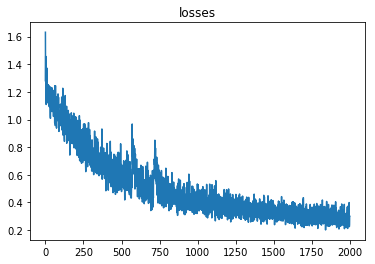

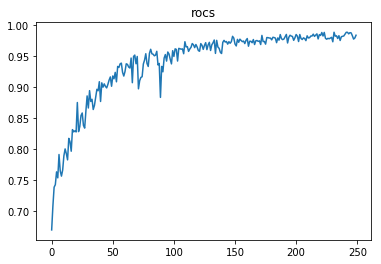

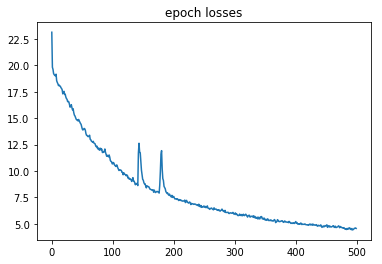

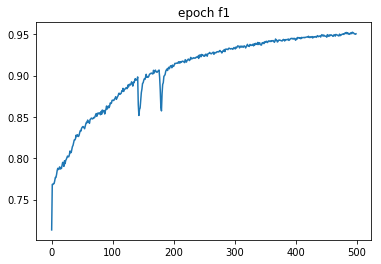

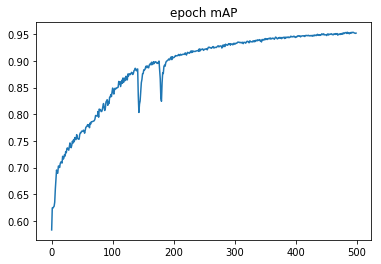

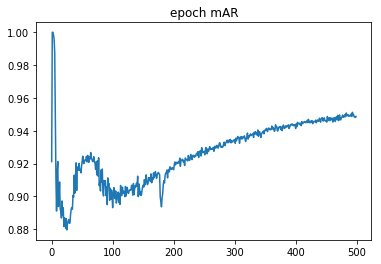

In [12]:
from matplotlib import pyplot as plt

plt.plot(ps_losses)
plt.title('losses')
plt.show()

plt.plot(ps_rocs)
plt.title('rocs')
plt.show()

plt.plot(ps_losses_ep)
plt.title('epoch losses')
plt.show()

plt.plot(ps_f1_ep)
plt.title('epoch f1')
plt.show()

plt.plot(ps_mAP_ep)
plt.title('epoch mAP')
plt.show()

plt.plot(ps_mAR_ep)
plt.title('epoch mAR')
plt.show()

In [10]:
save_res = True

if save_res:
    # directory
    save_dir = 'files_MS_aug_bgr_PreImageNet'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # save the model
    model_path = 'jstars_bgr_PreImageNet_ms_aug_ep{}_step{}_b{}.pt'.format(num_epochs, ps_step, bsize)
    model_path = os.path.join(save_dir, model_path)
    save = lambda ep: torch.save({
            'model': ps_model.state_dict(),
            'epoch': ep,
            'step': ps_step,
        }, str(model_path))

    save(model_path)

    # save the AUCs
    auc_path = 'auc_bgr_PreImageNet_ms_aug_ep{}_step{}_b{}.txt'.format(num_epochs, ps_step, bsize)
    auc_path = os.path.join(save_dir, auc_path)
    np.savetxt(auc_path, np.array(ps_rocs))

    #save the loss vectors
    ep_loss_path = 'losses_ep_bgr_PreImageNet_ms_aug_ep{}_step{}_b{}.txt'.format(num_epochs, ps_step, bsize)
    ep_loss_path = os.path.join(save_dir, ep_loss_path)
    np.savetxt(ep_loss_path, np.array(ps_losses_ep))

    #save the total loss vector
    loss_path = 'loss_bgr_PreImageNet_ms_aug_ep{}_step{}_b{}.txt'.format(num_epochs, ps_step, bsize)
    loss_path = os.path.join(save_dir, loss_path)
    np.savetxt(loss_path, np.array(ps_losses))
    
    # save the f1's
    f1_path = 'f1_bgr_PreImageNet_ms_aug_ep{}_step{}_b{}.txt'.format(num_epochs, ps_step, bsize)
    f1_path = os.path.join(save_dir, f1_path)
    np.savetxt(loss_path, np.array(ps_f1_ep))
    
    # save the f1's
    f1_path = 'f1_bgr_PreImageNet_ms_aug_ep{}_step{}_b{}.txt'.format(num_epochs, ps_step, bsize)
    f1_path = os.path.join(save_dir, f1_path)
    np.savetxt(f1_path, np.array(ps_f1_ep))
    
    # save the mAPs
    mAP_path = 'mAP_bgr_PreImageNet_ms_aug_ep{}_step{}_b{}.txt'.format(num_epochs, ps_step, bsize)
    mAP_path = os.path.join(save_dir, mAP_path)
    np.savetxt(mAP_path, np.array(ps_mAP_ep))
    
    # save the mARs
    mAR_path = 'mAR_bgr_PreImageNet_ms_aug_ep{}_step{}_b{}.txt'.format(num_epochs, ps_step, bsize)
    mAR_path = os.path.join(save_dir, mAR_path)
    np.savetxt(mAR_path, np.array(ps_mAR_ep))
  

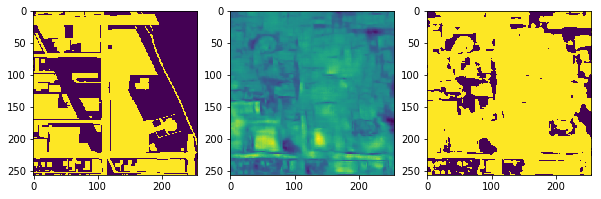

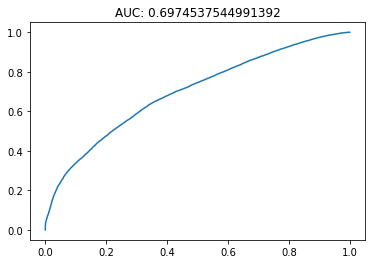

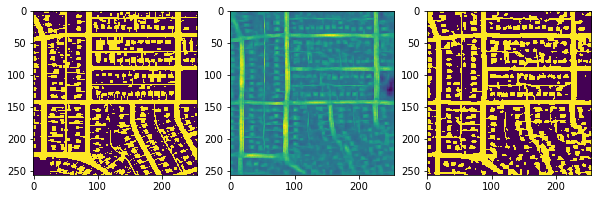

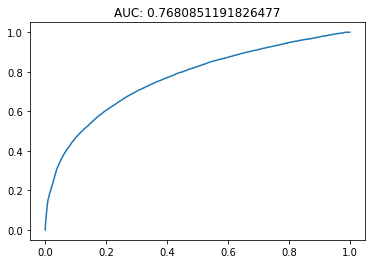

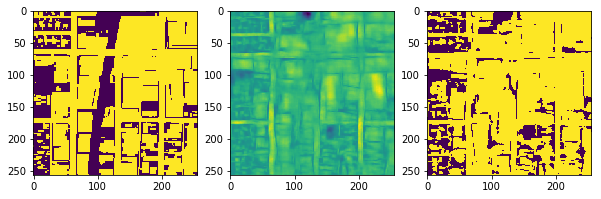

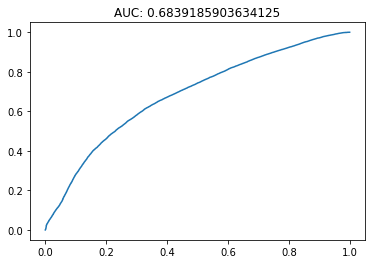

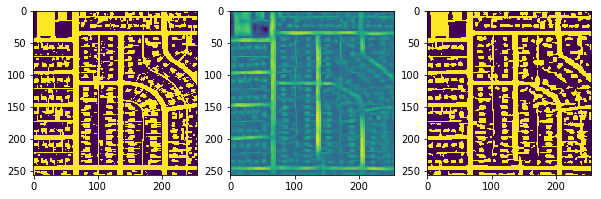

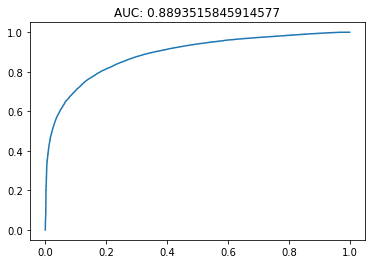

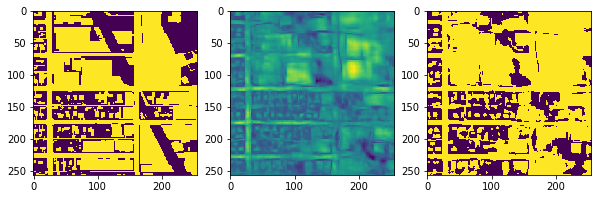

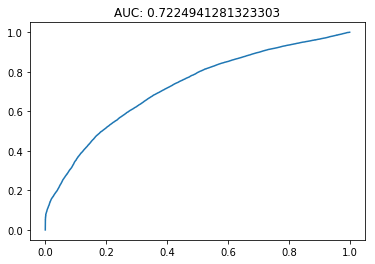

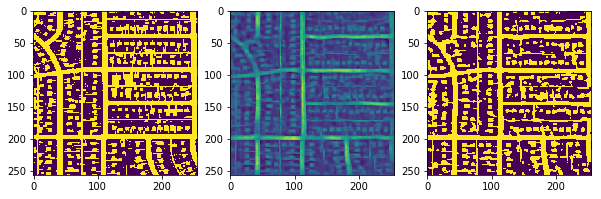

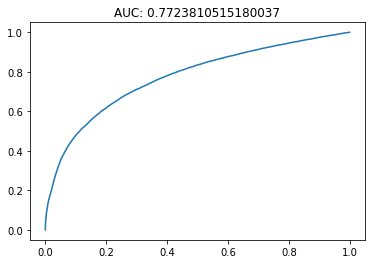

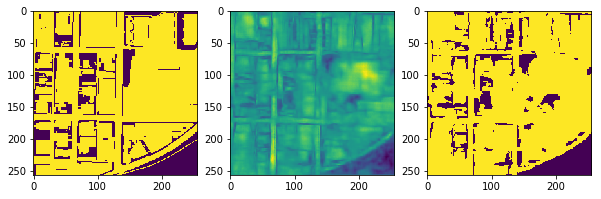

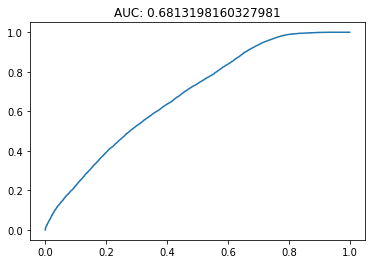

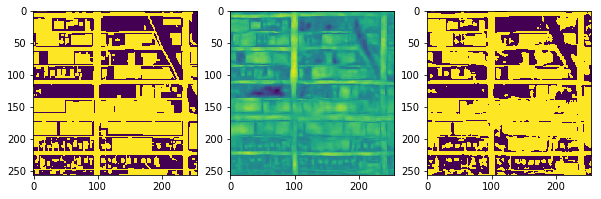

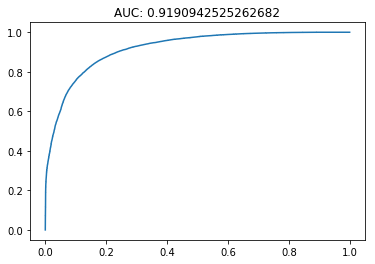

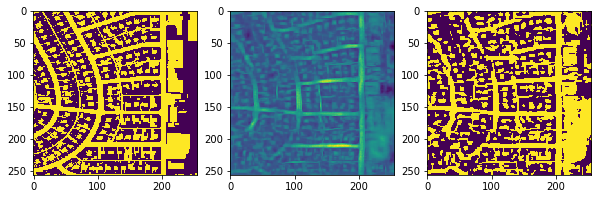

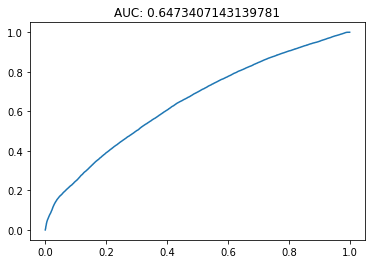

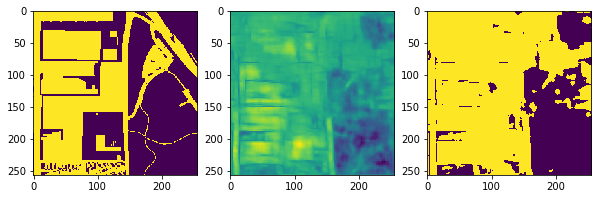

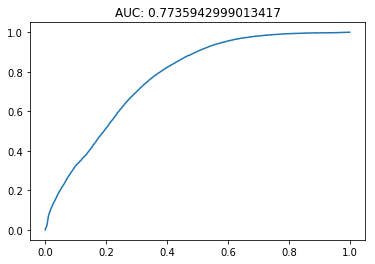

In [11]:
ps_model.eval()
for ind in range(0,10):
    fig, ax = plt.subplots(1,3, figsize=(10,5))
    test_im, test_target = ps_test_ds[ind]
    test_out = ps_model(variable(test_im.unsqueeze(0)))
    ax[0].imshow(test_target.numpy()[0])

    out = test_out.cpu().detach().numpy()[0][0]
    ax[1].imshow(out)

    ax[2].imshow(out>0)
    #ax[2].imshow(test_im.unsqueeze(0).cpu().detach().numpy()[0][0])
    plt.show()
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_target.numpy().flatten(), out.flatten())
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate)
    plt.title('AUC: {}'.format(roc_auc))